
# <center>Import Required Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

# <center>Make Dataframe That Consists Of Filepaths And Labels</center>

In [2]:
import pathlib
sdir = r"archive/Processed Images_Fruits"
bad_path = r"archive/Processed Images_Fruits/Bad Quality_Fruits"
good_path = r"archive/Processed Images_Fruits/Good Quality_Fruits"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            filepaths.append(img_path)
            labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 

,filepaths,labels
0,archive/Processed Images_Fruits/Bad Quality_Fr...,Apple_Bad
1,archive/Processed Images_Fruits/Bad Quality_Fr...,Apple_Bad
2,archive/Processed Images_Fruits/Bad Quality_Fr...,Apple_Bad
3,archive/Processed Images_Fruits/Bad Quality_Fr...,Apple_Bad
4,archive/Processed Images_Fruits/Bad Quality_Fr...,Apple_Bad
...,...,...
18447,archive/Processed Images_Fruits/Good Quality_F...,Pomegranate_Good
18448,archive/Processed Images_Fruits/Good Quality_F...,Pomegranate_Good
18449,archive/Processed Images_Fruits/Good Quality_F...,Pomegranate_Good
18450,archive/Processed Images_Fruits/Good Quality_F...,Pomegranate_Good


In [3]:
df['labels']=df['labels'].astype('category')

In [4]:
df['labels'].value_counts()

labels
Pomegranate_Good    5940
Orange_Good         1216
Pomegranate_Bad     1187
Orange_Bad          1159
Guava_Good          1152
Apple_Good          1149
Apple_Bad           1141
Guava_Bad           1129
Banana_Good         1113
Lime_Good           1094
Banana_Bad          1087
Lime_Bad            1085
Name: count, dtype: int64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

df['labels'].unique()

['Apple_Bad', 'Banana_Bad', 'Guava_Bad', 'Lime_Bad', 'Orange_Bad', ..., 'Banana_Good', 'Guava_Good', 'Lime_Good', 'Orange_Good', 'Pomegranate_Good']
Length: 12
Categories (12, object): ['Apple_Bad', 'Apple_Good', 'Banana_Bad', 'Banana_Good', ..., 'Orange_Bad', 'Orange_Good', 'Pomegranate_Bad', 'Pomegranate_Good']

# <center>Plot Random Images from Dataframe</center>

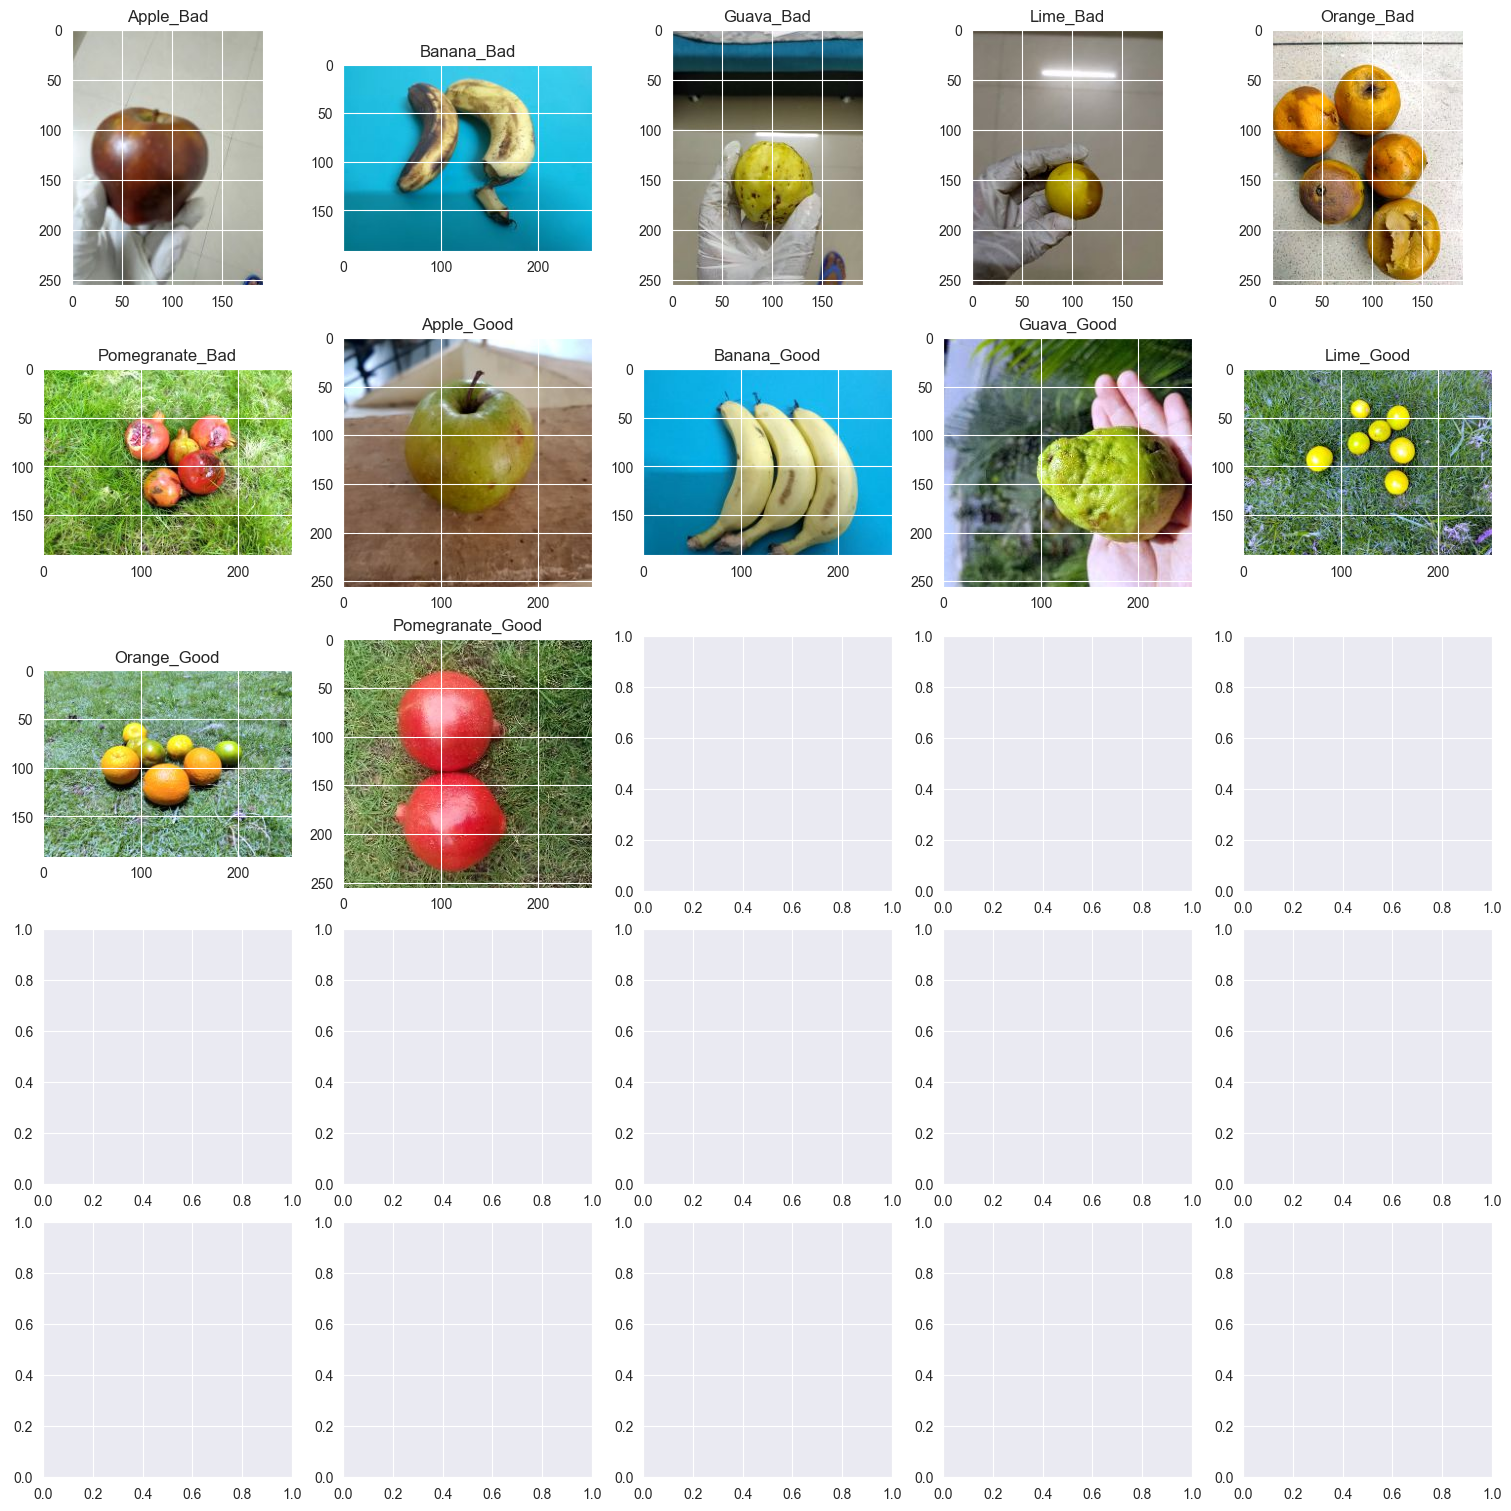

In [6]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['labels'].unique():
    
    ax[j].imshow(plt.imread(df[df['labels']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

# <center>Call train_test_split </center>

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(df, test_size=0.2, random_state=123)

In [8]:
print(X_train.shape)
print(X_test.shape)

(14761, 2)
(3691, 2)


# <center>Split images into Training, Test, And Valildation Sets</center>

In [9]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                              validation_split=0.2)
testGen =ImageDataGenerator(preprocessing_function= preprocess_input)
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                           x_col='filepaths', 
                                           y_col='labels',
                                           class_mode='categorical', 
                                           subset='training', 
                                           batch_size=32)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                         x_col='filepaths', 
                                         y_col='labels',
                                         class_mode='categorical', 
                                         subset='validation',
                                         batch_size=32)
X_test_img =testGen.flow_from_dataframe(dataframe=X_test, 
                                        x_col='filepaths', 
                                        y_col='labels',
                                        class_mode='categorical', 
                                        batch_size=32, 
                                        shuffle=False)

Found 11809 validated image filenames belonging to 12 classes.
Found 2952 validated image filenames belonging to 12 classes.
Found 3691 validated image filenames belonging to 12 classes.


# <center>Display Images Along with One-Hot-Encoding Values</center>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


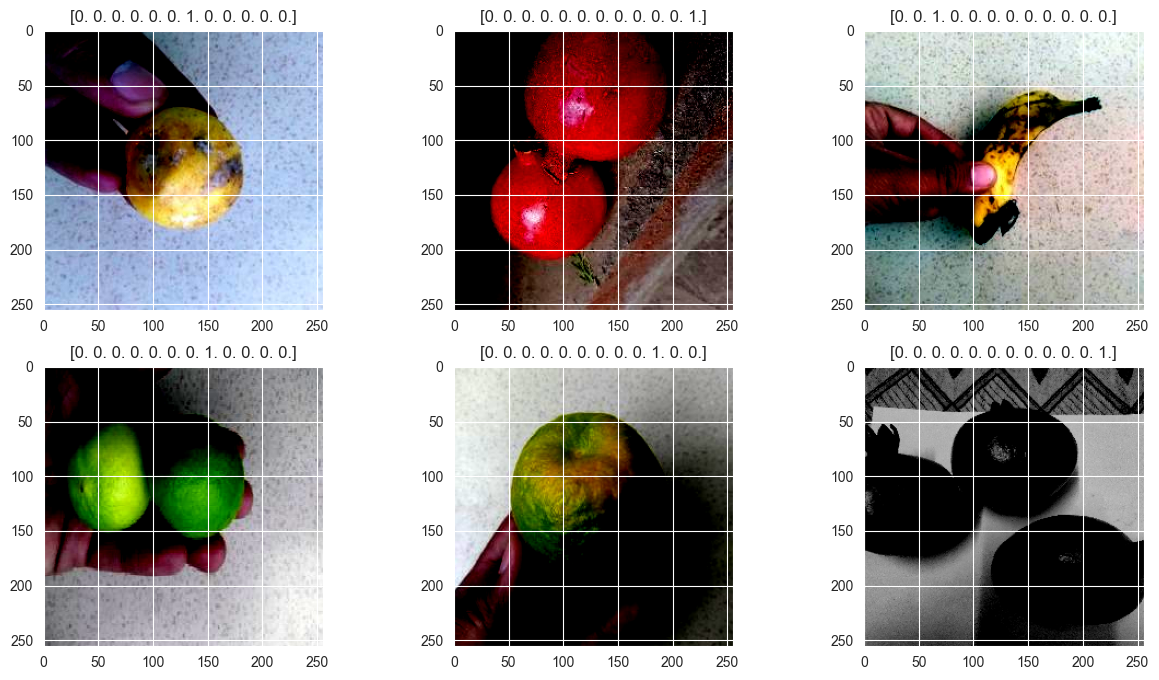

In [10]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = X_test_img.next()
    #print(img.shape)   #  (1,256,256,3)
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    #plt.show()
    j=j+1

In [11]:
X_test_img[0][0].shape

(32, 256, 256, 3)

In [12]:
image_shape=(256,256,3)

In [13]:
X_train_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Banana_Bad': 2,
 'Banana_Good': 3,
 'Guava_Bad': 4,
 'Guava_Good': 5,
 'Lime_Bad': 6,
 'Lime_Good': 7,
 'Orange_Bad': 8,
 'Orange_Good': 9,
 'Pomegranate_Bad': 10,
 'Pomegranate_Good': 11}

In [14]:
X_val_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Banana_Bad': 2,
 'Banana_Good': 3,
 'Guava_Bad': 4,
 'Guava_Good': 5,
 'Lime_Bad': 6,
 'Lime_Good': 7,
 'Orange_Bad': 8,
 'Orange_Good': 9,
 'Pomegranate_Bad': 10,
 'Pomegranate_Good': 11}

In [15]:
X_test_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Banana_Bad': 2,
 'Banana_Good': 3,
 'Guava_Bad': 4,
 'Guava_Good': 5,
 'Lime_Bad': 6,
 'Lime_Good': 7,
 'Orange_Bad': 8,
 'Orange_Good': 9,
 'Pomegranate_Bad': 10,
 'Pomegranate_Good': 11}

# <center>Data Augmentation</center>

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

# <center>Using InceptionResNetV2 As A Base Model</center>

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
pre_trained= InceptionResNetV2(include_top=False, input_shape=image_shape)

pre_trained.trainable=False

inputs = pre_trained.input
x = data_augmentation(inputs)
x = pre_trained(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output=Dense(12, activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)



base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 12)                18444 

# <center>Model Training On Current Inputs</center>

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

initial_epoch = 10
results = model.fit(X_train_img,epochs= initial_epoch,
                              validation_data=X_val_img, callbacks=[early_stop])

Epoch 1/10
370/370 [==============================] - 1088s 3s/step - loss: 1.6722 - accuracy: 0.4719 - val_loss: 0.9203 - val_accuracy: 0.7300
Epoch 2/10
370/370 [==============================] - 1742s 5s/step - loss: 0.9236 - accuracy: 0.7128 - val_loss: 0.6251 - val_accuracy: 0.8401
Epoch 3/10
370/370 [==============================] - 1756s 5s/step - loss: 0.7017 - accuracy: 0.7867 - val_loss: 0.5144 - val_accuracy: 0.8675
Epoch 4/10
370/370 [==============================] - 1749s 5s/step - loss: 0.5894 - accuracy: 0.8205 - val_loss: 0.4371 - val_accuracy: 0.8869
Epoch 5/10
370/370 [==============================] - 1757s 5s/step - loss: 0.5235 - accuracy: 0.8395 - val_loss: 0.3945 - val_accuracy: 0.8980
Epoch 6/10
370/370 [==============================] - 1755s 5s/step - loss: 0.4728 - accuracy: 0.8565 - val_loss: 0.3571 - val_accuracy: 0.9018
Epoch 7/10
370/370 [==============================] - 1756s 5s/step - loss: 0.4398 - accuracy: 0.8643 - val_loss: 0.3327 - val_accuracy:

# <center>Accuracy and Loss</center>

Text(0.5, 1.0, 'Loss')

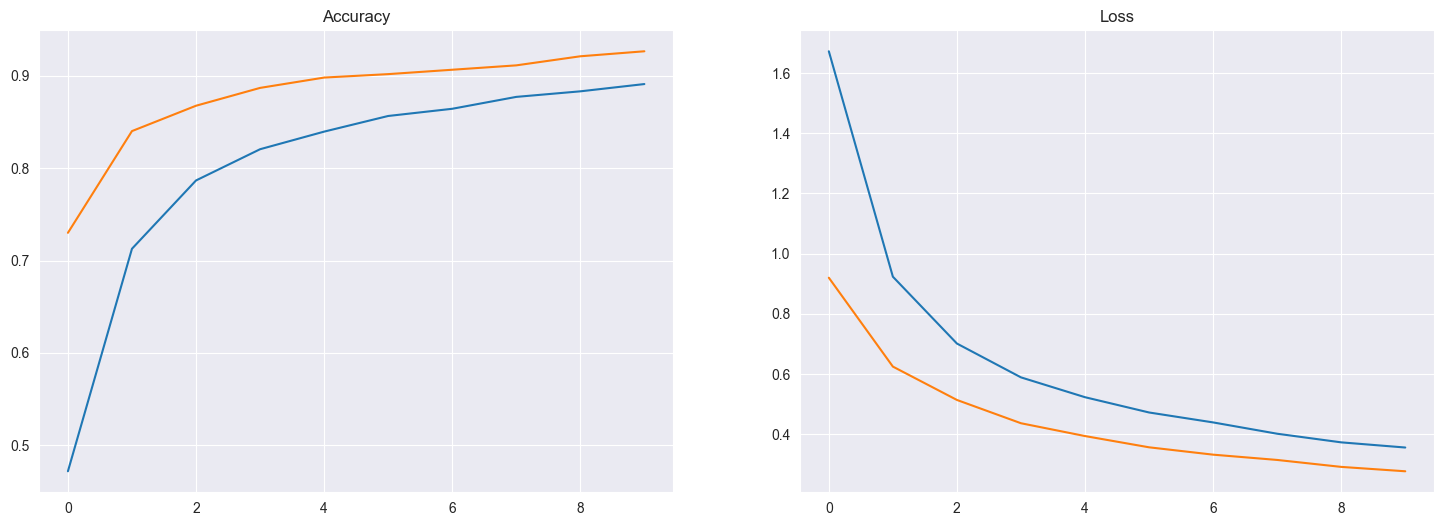

In [20]:

result_df = pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result_df[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result_df[['loss','val_loss']])
ax[1].set_title("Loss")

In [21]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

116/116 [==============================] - 437s 4s/step


In [22]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

# <center>Confusion Matrix</center>

Accuracy Score: 0.9246816580872392


<Axes: >

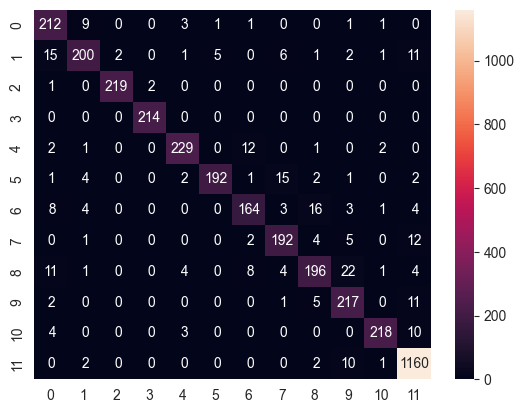

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')

                                               filepaths            labels  \
3719   archive/Processed Images_Fruits/Bad Quality_Fr...          Lime_Bad   
2143   archive/Processed Images_Fruits/Bad Quality_Fr...        Banana_Bad   
14673  archive/Processed Images_Fruits/Good Quality_F...  Pomegranate_Good   
16804  archive/Processed Images_Fruits/Good Quality_F...  Pomegranate_Good   
3116   archive/Processed Images_Fruits/Bad Quality_Fr...         Guava_Bad   
13411  archive/Processed Images_Fruits/Good Quality_F...  Pomegranate_Good   

                   pred  
3719           Lime_Bad  
2143         Banana_Bad  
14673  Pomegranate_Good  
16804  Pomegranate_Good  
3116          Guava_Bad  
13411  Pomegranate_Good  


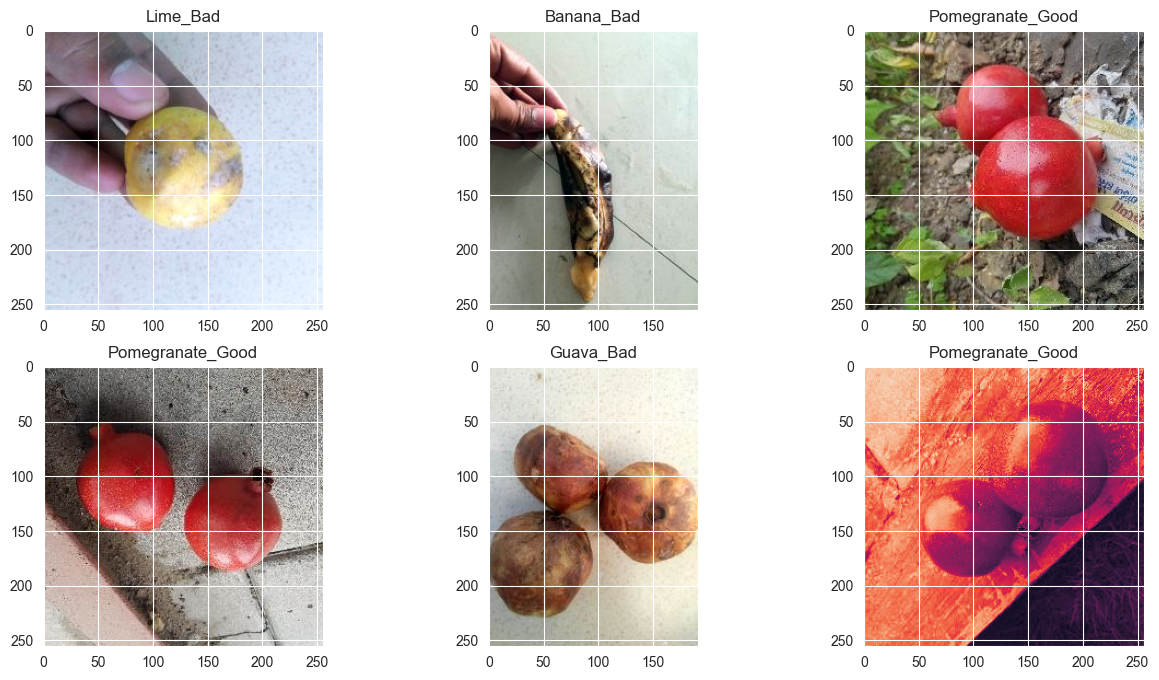

In [24]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(6))
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(6).reset_index()
for i in range(0,6):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])

# <center>Save Model</center>

In [34]:
model.save("fruitNet.h5")